In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# udemy_folder = "/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews"
# !cp {udemy_folder}/udemy_reviews.zip udemy_reviews.zip

#### Load the libraries

In [2]:
# !pip3 install -q -U spacy
# !python3 -m spacy download es_core_news_md

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

### Connect to drive to get the data

In [4]:
df_udemy = pd.read_csv(f'udemy_reviews.zip', compression='zip', header=0, sep=',', quotechar='"')
df_udemy.head()

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro
3,47366486,1640654,5.00,Excelente !!!,Márcio Maurício Soares do Nascimento
4,79933910,88380,5.00,Excelente todo!,Emilio Monarrez Hernandez


In [5]:
df_news = df_udemy

In [6]:
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
#df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que tienen menos de 5 palabras
df_news = df_news[df_news['comment'].str.split().str.len().gt(10)]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)

df_news.reset_index(inplace=True)
display(df_news.sample(10))

# Recomendación:
# usar los comentarios con >=5 palabras


,index,id,course,rating,comment,user,tag
6974,83996,77390026,1561272,1.00,"El curso es para PRINCIPIANTES. Desde mi punto de vista, el profesor va a una velocidad que no se puede seguir.\n\nSeria tan fácil como que el profesor, al enseñar una cancion nueva, mantuviera las teclas pulsadas para poder seguirle.\n\nMuy decepcionado.",Jaime Rul·lan,neg
9273,115769,72598666,2076884,3.00,"Un buen curso con consejos utiles, sin embargo, para quienes hemos indagado en el ambito con anterioridad, el inicio es algo pesado. Recomendamos que si tienes tu programa y ya sabes utilizarlo, moverte la Leccion 8.",John J. Wayne,neg
10968,140479,68332549,2551037,3.50,"Muy buen curso introductorio, lo que me llama la atención es que este es el primer curso que no tiene la parte practica que es lo que en lo personal a mi me fascina, fuera de eso la información es genial.",Adrián Mario Méndez Guzmán,neg
4575,55997,49875176,47492,3.50,"Práctico y claro... Lo único es que hay que actualizar al 2020 las versiones porque la que usted usó en su instalación, 2.2.24, ya no existe. Esto crea confunsión!",Francisco S. Barralaga,neg
12109,156358,87881118,2287845,1.00,"Es un curso básico que no tiene nada que ver con la vida laboral... A parte, no explica bien el funcionamiento de los mismos. Llama ""esto"" a parámetros y no explica para que se utiliza y el por qué. Es un curso mínimo de repaso para alguien que sabe php, pero no es un curso para aprender algo nuevo.",Angel,neg
2231,27661,52707716,2545223,3.50,"Si claro, aunque tal vez siento que necesitaría explicar mejor, no se escucha muy bien el audio.",Claudia Aguilar Cisneros,neg
11114,143402,34926286,1392960,1.00,"Se nota demasiado que los videos aunque están ordenados, existen vacíos que hace que el anterior no tenga un hilo con el siguiente. Es una medida de marketing, lo cual está bien pero hubiese sido (éticamente) correcto el especificar ello y mejor aún: de mostrar la versión completa acá en udemy, la cual, se encuentra en otra plataforma. No me enseñó nada nuevo, si fuese pago ya hubiese pedido devolución del dinero. Hay partes en que se nota que improvisa :S",Carlos Orrego Díaz,neg
7719,93493,78241530,2437520,1.00,"Lo veo bien simple el curso, videos de un minuto donde explican casi nada.",Luis Valderrama,neg
4388,53849,68778029,1997472,3.00,"El instructor tiene mucha experiencia sin lugar a dudas, pero le falta mucha calidad en sus vídeos, estoy seguro que podría mejorar la edición (un poquito de esfuerzo). Por otro lado, yo sugiero que se actualice el curso, mucho es 2018 y ya estamos a casi tres años de esa fecha, hay mucho que ha cambiado y que se podría agregar. \n\nEs verdad que te da una buena noción de lo que es el marketing para el lanzamiento de juegos, sin embargo, creo que los conocimientos son muy superficiales, creo que podrían ahondar más en muchos temas. \n\nQué quiero decir, que el curso se quedó un poco corto en cuanto a mis expectativas, venía recomendado del profesor Gomila y esperaba mucho más. Sin embargo, ojo, no es un mal curso, te da una noción básica del marketing en videojuegos. \n\nFinalmente quiero decir, que tengo mucho respeto y admiración por los profesores Coronado y Gomila, ambos con tanta experiencia y carisma. Si realizaran un curso más avanzado sin lugar a dudas lo compraría. \n\nEspero que se agreguen más entrevistas (con calidad en el vídeo por favor, la última está fatal) y algunas clases actualizadas o que profundicen ciertos temas. \n\nGracias por el curso y seguramente nos veremos en algún otro curso.",Roberto Ricardo Contreras Ceballos,neg
9510,120086,76634574,1717394,3.00,Es muy completo pero a nivel didáctico se podría mejorar. El sonido en algunos capítulos no es bueno y las explicaciones del profesor podrían acompañarse con ejemplos gráficos más amenos.,Susana Peña,neg


In [7]:
df_news[df_news['id'].isin([76629358,52215828])]

,index,id,course,rating,comment,user,tag
743,9035,52215828,1922200,3.00,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale",Diana Forero,neg
4482,54928,76629358,3446356,3.50,"Buenos días, si estás leyendo este comentario, te recomiendo leerlo entero para tener un contexto global del por que dejo solo 3 estrellas. Primero dejaré unos puntos clave y luego la explicación.\n\nPrólogo: Enhorabuena a Nicolas Schurmann por su trabajo y acercar a más gente al mundo del desarrollo, y enhorabuena por el curso que pese a no cuadrar conmigo está muy bien.\n\nPrimero: El curso lo recibí de forma gratuita por una promoción.\nSegundo: Lo explicado en el curso, está bien explicado.\nTercero: Recomiendo el curso a cualquier persona que no tenga ningún conocimiento del mundo de desarrollo.\nCuarto: No recomiendo el curso a las personas que ya tengan contacto con el mundo del desarrollo. \nQuinto: Soy desarrollador Junior trabajando con lenguajes POO como Java y C# en mi día a día. \nSexto: A la hora de escribir este comentario miré y practiqué hasta la sección 12 (inclusive).\n\nExposición: \nEl título expone muchas tecnologías, cosa que ya me decía que faltarían aspectos interesantes por tocar, yo ya se lo básico de HTML, CSS y algo más avanzado en MySQL, no se que es Flask y no conocía la sintaxis de Python. Mi interés en este curso es principalmente Python, nada más, aún que veré el resto de secciones por si acaso. \n\nDicho esto la sección de Python me parece demasiado básica, echando en falta explicación de conceptos como; ámbito de vida de las variables, uso de variables de forma global, funcionamiento extendido a la hora de iterar diccionarios y otro tipo de colecciones, propagación de excepciones y algunos temas más avanzados. \n\nPilares de la OO, se explica la creación de clases y su herencia, pero no se explican conceptos como el polimorfismo que me parece de vital importancia en la POO, tampoco se hace mención a la abstracción y el encapsulamiento, pese a explicar la creación de funciones en clases al ser python un lenguaje no tipado (o poco tipado) no queda claro el tema del encapsulamiento, no se explica en el curso, en las clases creadas siempre se tiene acceso a las propiedades y eso va en contra de este principio.\n\nEn un capítulo se explica la recursividad, es algo muy potente pero que si no se tienen conocimientos puede dar pie a confusión y errores, desearía algún ejemplo más de recursividad para los más inexpertos. \n\nEn resumen, falta un poco de explicación teórica sobre los principios de la POO y falta algo más de contenido sobre Python, lo explicado está perfectamente explicado (menos la recursividad en mi opinión). \n\nCon el título ""python sin fronteras"" esperaba mucho más contenido sobre python, como dije el curso lo recomiendo a cualquier persona que quiera iniciarse, pero si ya controlas aún que sea como junior algún lenguaje de programación, no creo que este curso sea para ti. \n\nMe sabe mal dejar tan baja puntuación a Nicolas Schurmann por que su contenido es muy bueno, tanto en esta plataforma como en otras, pero no me queda más remedio que ser objetivo, quizás si el título fuera algo así como ""Iniciación en Python"" o algo similar no hubiera escrito este comentario y le hubiera dado 4.5 estrellas o 5, ya que es 100% apto para los no iniciados. \n\nSin más me despido, un saludo y espero os toméis este comentario como lo que es, un comentario que intenta dar un punto de vista como un junior que quiere aprender.",Ramón Martínez Nieto,neg


In [8]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [9]:
df_news['tag'].value_counts()

neg    13509
Name: tag, dtype: int64

In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13509 entries, 0 to 13508
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    13509 non-null  int64  
 1   id       13509 non-null  int64  
 2   course   13509 non-null  int64  
 3   rating   13509 non-null  float64
 4   comment  13509 non-null  object 
 5   user     13509 non-null  object 
 6   tag      13509 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 738.9+ KB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

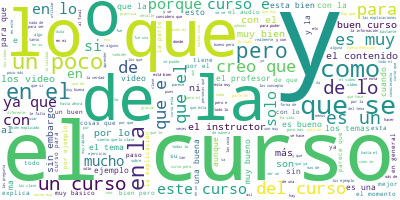

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_news['comment'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [76]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelente', 'buen','bien','aunque',
              'muchas', 'gracias', 'curso','course','good'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [77]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

Wall time: 3.52 s


In [78]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [79]:
cleaner('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo',
 'adentraste',
 'informaste',
 'publicar',
 'mejor',
 'facebook',
 'recomendacion',
 'mejora',
 'diccion']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [80]:
stemmization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción')

['curso',
 'gracias',
 'amigo',
 'me',
 'adentraste',
 'e',
 'informaste',
 'como',
 'publicar',
 'mejor',
 'en',
 'facebook',
 'ads',
 'recomendacion',
 'mejora',
 'tu',
 'diccion']

In [81]:
lemmatization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo', 'recomendación', 'dicción']

In [82]:
len(df_news)

13509

In [83]:
# !python -m spacy download es_core_news_md

In [84]:
df_news['comment'].sample(3)

7536    El curso ya no sirve. Cuando intento seguirlo me da muchísimos errores porque no es la versión más reciente. El mismo profesor ha abierto otro curso con la versión 4 de IONIC, pero tengo que volver a pagar. Este curso no me sirve de mucho ahora mismo.
5920                                                                                                                            El maestro se enfoco solo en linux, yo utilizo windows y unos ejemplos no me salieron por lo cual ya no pude continuar con el curso
193                             Hasta el momento el tutor a leído las presentaciones, hace falta aclarar algunas cosas para que se pueda entrar más al detalle y de pronto aprender más sobre la experiencia que tiene el tutor con la aplicación de dichas frases.
Name: comment, dtype: object

In [85]:
cleaner(df_news['comment'].iloc[3])

['parece',
 'podria',
 'algun',
 'peque',
 'repaso',
 'terminos',
 'comunes',
 'ademas',
 'ejempl']

The Cleaner function work properly

##### Let's clean all the text

In [86]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

  0%|          | 0/13509 [00:00<?, ?it/s]

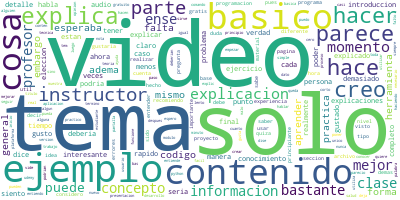

In [87]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(map(str, l)) for l in df_news['comment_cleaned']]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [88]:
# las palabras "curso,clase" son stopwords

In [89]:
df_news['comment_cleaned'].iloc[200:210]

200                                                                                                                              [secciones, repetidas, dentro, misma, clase, veces, coincide, texto, diapositivas, muestr]
201                                                                                               [interlocutor, habla, tono, aburrido, completamente, material, diapositivas, permite, enriquecer, conomiento, tema, trat]
202                                                                                                                                           [bueno, slays, concuerdan, habla, solo, habla, queda, pegado, anterior, slay]
203                                                                                                                                        [diapositivas, estan, repetidas, contienen, errores, traduccion, palabras, ileg]
204    [dejo, puntos, explicar, imagenes, correspondian, explicado, ejemplo, explico, procesos, comunes, proyecto, fases

In [92]:
df_news[df_news["id"]==52707716]#['comment_cleaned'].iloc[]

,index,id,course,rating,comment,user,tag,comment_cleaned
2231,27661,52707716,2545223,3.50,"Si claro, aunque tal vez siento que necesitaría explicar mejor, no se escucha muy bien el audio.",Claudia Aguilar Cisneros,neg,"[claro, siento, necesitaria, explicar, mejor, escucha, audi]"


In [93]:
dictionary = Dictionary(df_news['comment_cleaned'].to_list())
dictionary.compactify()
# Filter extremes
#dictionary.filter_extremes(no_below=5, no_above=0.3)#, keep_n=10000)
#dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [94]:
%%capture
!pip install pyLDAvis==2.1.2

%%capture
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Faolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
# LDA MODEL

In [97]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

Find out the optimal number of topics for the LDA model based on the coherence metric:

In [116]:
from tqdm import tqdm_notebook

def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    seed=12387
    
    c_v = []
    lm_list = []
    for num_topics in tqdm_notebook(range(1, limit), 
                         total=limit-1, 
                         desc="Evaluating graph"):
        ldamodel_temp = LdaMulticore(corpus=corpus, 
                                     num_topics=num_topics, 
                                     id2word=dictionary, 
                                     workers=2,
                                     chunksize=2e3, 
                                     passes=10, 
                                     iterations = 200, 
                                     #update_every=100,
                                     eval_every=1e2,
                                     minimum_probability=0.1,
                                     random_state = seed)
        lm_list.append(ldamodel_temp)
        cm = CoherenceModel(model=ldamodel_temp, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

Evaluating graph:   0%|          | 0/30 [00:00<?, ?it/s]

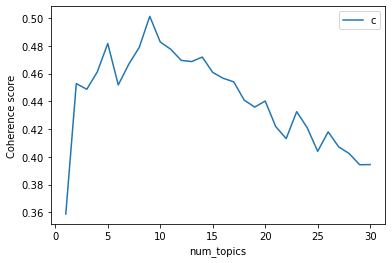

In [117]:
ldalist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), limit=31)

For this model it seems that  10, again we must to check the keywords too.

In [99]:
from tqdm import tqdm_notebook


def evaluate_best_seed(dictionary, corpus, texts, num_topics, random_seeds):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    

    cm_max=0
    lda_max=0
    seed_max=0
    lda_list=[]
    c_v=[]

    for seed in tqdm_notebook(random_seeds, 
                         total=len(random_seeds), 
                         desc="LDA processing"):
        ldamodel_temp = LdaMulticore(corpus=corpus, 
                                     num_topics=num_topics, 
                                     id2word=dictionary, 
                                     workers=2,
                                     chunksize=2e3, 
                                     passes=10, 
                                     iterations = 200, 
                                     #update_every=100,
                                     eval_every=1e2,
                                     minimum_probability=0.1,
                                     random_state = seed)
        print(f"({seed})",end=" ")
        lda_list.append(ldamodel_temp)
        cm = CoherenceModel(model=ldamodel_temp, texts=texts, dictionary=dictionary, coherence='c_v')
        cm_temp = cm.get_coherence()
        print(cm_temp,end=" - ")
        c_v.append(cm_temp)
        if cm_temp>cm_max:
            lda_max=ldamodel_temp
            seed_max=seed
            cm_max=cm_temp
        
    # Show graph
    x = range(len(random_seeds))
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lda_max, seed_max

LDA processing:   0%|          | 0/1 [00:00<?, ?it/s]

(1346891) 0.49053351050425364 - 

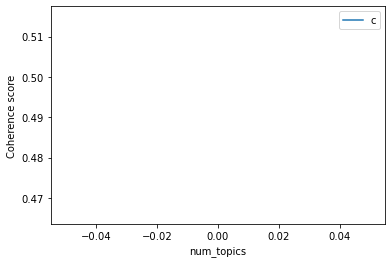

'rm' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file model already exists.
'rm' is not recognized as an internal or external command,
operable program or batch file.


guardado el modelo


[(0,
  '0.018*"temas" + 0.017*"version" + 0.016*"informacion" + 0.015*"falta" + 0.014*"explicacion"'),
 (1,
  '0.018*"explicar" + 0.014*"paso" + 0.010*"explica" + 0.008*"hacer" + 0.008*"profesor"'),
 (2,
  '0.018*"creo" + 0.017*"basico" + 0.015*"ejemplos" + 0.014*"tema" + 0.013*"podria"'),
 (3,
  '0.021*"falta" + 0.017*"conceptos" + 0.012*"explica" + 0.012*"solo" + 0.010*"parte"'),
 (4,
  '0.036*"videos" + 0.025*"audio" + 0.015*"calidad" + 0.015*"video" + 0.014*"contenido"'),
 (5,
  '0.013*"profesor" + 0.013*"hace" + 0.012*"solo" + 0.010*"forma" + 0.008*"clases"'),
 (6,
  '0.016*"videos" + 0.015*"solo" + 0.014*"video" + 0.011*"puede" + 0.011*"ense"'),
 (7,
  '0.018*"solo" + 0.017*"basico" + 0.014*"ense" + 0.014*"eleccion" + 0.012*"parece"'),
 (8,
  '0.016*"contenido" + 0.014*"explicacion" + 0.013*"explica" + 0.013*"conceptos" + 0.013*"parece"'),
 (9,
  '0.046*"cosas" + 0.022*"explica" + 0.015*"explicar" + 0.013*"hace" + 0.011*"demasiado"')]

In [100]:
num_topics=10
random_seeds = np.random.randint(100000, size=(30))
random_seeds = [1346891]#[129833]
ldamodel, best_seed = evaluate_best_seed(dictionary=dictionary, corpus=corpus, texts=df_news['comment_cleaned'].to_list(), num_topics=num_topics, random_seeds=random_seeds)
doc_lda = ldamodel[corpus]
best_seed

###########
from gensim.test.utils import common_corpus, common_dictionary
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel
import shutil

# Save model to disk.
!rm -rf model
!mkdir model
!rm -rf {udemy_folder + '/model'}
ldamodel.save("model/lda.model")
print("guardado el modelo")

try:
    shutil.copytree('model', udemy_folder + '/model')
except:
    pass

# Load a potentially pretrained model from disk.
ldamodel = LdaModel.load("model/lda.model")


###########
# Print the fist 6 Keywords in the 10 topics
ldamodel.print_topics(num_topics, 5)


In [102]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
5      0.07  0.01       1        1 13.25
2     -0.04  0.02       2        1 12.66
1      0.00  0.02       3        1 12.29
4      0.12  0.09       4        1 11.47
9      0.05  0.03       5        1 11.34
6      0.14  0.03       6        1  9.98
3     -0.07  0.00       7        1  8.79
8     -0.03  0.02       8        1  7.25
0     -0.24  0.07       9        1  6.85
7     -0.00 -0.28      10        1  6.12, topic_info=            Term     Freq    Total Category  logprob  loglift
139        cosas 1,160.00 1,160.00  Default    30.00    30.00
552        audio   460.00   460.00  Default    29.00    29.00
78        videos 1,170.00 1,170.00  Default    28.00    28.00
16      explicar   743.00   743.00  Default    27.00    27.00
599    conceptos   744.00   744.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
142  explicacion    50.98   827.21  Topic10    -5.25     0.01
78        videos    51.20 1,170.76  Topic10    -5.24    -0.34
23          tema    45.40   781.15  Topic10    -5.36    -0.05
210        poder    42.63   435.03  Topic10    -5.43     0.47
150        video    42.27   941.53  Topic10    -5.43    -0.31

[800 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3463      9  0.92  abordan
3132     10  0.96    about
535       1  0.05    aburr
535       8  0.73    aburr
535      10  0.18    aburr
...     ...   ...      ...
151       4  0.07  youtube
151       5  0.23  youtube
151       6  0.34  youtube
151       8  0.01  youtube
151      10  0.01  youtube

[2064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 10, 7, 4, 9, 1, 8])

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [103]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [104]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()
lda_coherence

0.32071477919609503

In [105]:
display_topics(ldamodel)

Topic 0:
temas version informacion falta explicacion deberia ejemplos esperaba interesante gustaria 

Topic 1:
explicar paso explica hacer profesor proyecto ejemplo tener mejor solo 

Topic 2:
creo basico ejemplos tema podria nivel mejor solo conceptos ejemplo 

Topic 3:
falta conceptos explica solo parte ejercicios programacion basicos ejemplos creo 

Topic 4:
videos audio calidad video contenido informacion mejorar mejor explicacion parece 

Topic 5:
profesor hace solo forma clases basico mejor codigo conceptos temas 

Topic 6:
videos solo video puede ense momento contenido presentacion informacion visto 

Topic 7:
solo basico ense eleccion parece hacer instructor mejor introduccion linux 

Topic 8:
contenido explicacion explica conceptos parece habla tema tem introduccion falta 

Topic 9:
cosas explica explicar hace demasiado basico rapido hacer explicaciones aprender 



It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


Let´s check the keyword when we selecting another number of topics (14)

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [106]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, doc_lda=None, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in tqdm_notebook(enumerate(doc_lda), total=len(doc_lda)):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic_number', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel, doc_lda=doc_lda, texts=df_news['comment_cleaned'].to_list())
df_topic_sents_keywords = format_topics_sentences(ldamodel, doc_lda=doc_lda, texts=df_news['comment'].to_list())



  0%|          | 0/13509 [00:00<?, ?it/s]

In [107]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_number', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text
0,0,7.00,0.59,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux",como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS
1,1,4.00,0.63,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio."
2,2,2.00,0.46,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos"
3,3,8.00,0.58,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta","Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos"
4,4,5.00,0.60,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas",Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.
5,5,6.00,0.60,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto","No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada."
6,6,6.00,0.57,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto",habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.
7,7,0.00,0.40,"temas, version, informacion, falta, explicacion, deberia, ejemplos, esperaba, interesante, gustaria","Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje."
8,8,2.00,0.45,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo",Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python
9,9,5.00,0.46,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas","Muy mal, la publicitan como hacking con python y el 90% del curso solo es el preambulo y al final solo te da el codigo de frente y no te dice como lo hizo, me siento estafado."


In [115]:
topic_nums=range(10)
for topic_num in topic_nums:
    print(topic_num)
    print(ldamodel.show_topic(topic_num))
    display(df_dominant_topic[df_dominant_topic["Dominant_Topic_number"]==topic_num].sort_values("Topic_Perc_Contrib",ascending=False)["Text"].head(4).tolist())
    print()

0
[('temas', 0.018332608), ('version', 0.016877582), ('informacion', 0.01576714), ('falta', 0.01454716), ('explicacion', 0.013653057), ('deberia', 0.011959253), ('ejemplos', 0.011419032), ('esperaba', 0.010760451), ('interesante', 0.009923366), ('gustaria', 0.009441767)]


['El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.',
 'El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.',
 'Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.',
 'la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.']


1
[('explicar', 0.018331844), ('paso', 0.014123334), ('explica', 0.009632547), ('hacer', 0.008315461), ('profesor', 0.007847014), ('proyecto', 0.0074809357), ('ejemplo', 0.0072999876), ('tener', 0.007188237), ('mejor', 0.0070553795), ('solo', 0.006615273)]


['Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.',
 'Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.',
 'Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad


2
[('creo', 0.017740551), ('basico', 0.016996715), ('ejemplos', 0.015167167), ('tema', 0.0143293105), ('podria', 0.012605028), ('nivel', 0.010374517), ('mejor', 0.009211609), ('solo', 0.008764898), ('conceptos', 0.008283913), ('ejemplo', 0.0071921158)]


['Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde "explica" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir',
 'Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: "Mi primera aplicación con Android (Primeros pasos)". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API\'s y la elección de estás.',
 'seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.',
 'Cumplió con mis expectativas de apren


3
[('falta', 0.02112924), ('conceptos', 0.017165761), ('explica', 0.012150118), ('solo', 0.011533389), ('parte', 0.01031506), ('ejercicios', 0.009163799), ('programacion', 0.008761048), ('basicos', 0.0085406955), ('ejemplos', 0.008325609), ('creo', 0.007732302)]


['Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su "trabajo".',
 'Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas',
 'Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que e


4
[('videos', 0.03557409), ('audio', 0.025063245), ('calidad', 0.015417595), ('video', 0.014812847), ('contenido', 0.013712426), ('informacion', 0.012223801), ('mejorar', 0.011098064), ('mejor', 0.010130064), ('explicacion', 0.0091609005), ('parece', 0.008742268)]


['Falta mas seriedad del instructor, dice mucho " eh, eh, eh, perdon, eh, eh, perdon." no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente  de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.',
 'Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una "muletilla" deseperante que esta en la mayoría de las lecciones que vi, es un "ehh, ehh, ehh" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.',
 'Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la 


5
[('profesor', 0.012601818), ('hace', 0.012521222), ('solo', 0.012320195), ('forma', 0.009869721), ('clases', 0.008016671), ('basico', 0.007745398), ('mejor', 0.0066153915), ('codigo', 0.0064034085), ('conceptos', 0.006386699), ('temas', 0.0060220626)]


['Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo "como vimos al final de la unidad anterior" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al 


6
[('videos', 0.015525432), ('solo', 0.014996568), ('video', 0.0136888735), ('puede', 0.0106143), ('ense', 0.010544723), ('momento', 0.009770916), ('contenido', 0.009030324), ('presentacion', 0.008603166), ('informacion', 0.008364057), ('visto', 0.007891148)]


['empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.',
 'Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.',
 'al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva  a la misma página, ofre


7
[('solo', 0.018478401), ('basico', 0.016931616), ('ense', 0.01383008), ('eleccion', 0.013503557), ('parece', 0.011532184), ('hacer', 0.011314513), ('instructor', 0.009742705), ('mejor', 0.009032673), ('introduccion', 0.007768075), ('linux', 0.0076965434)]


["So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.",
 "I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.",
 'Things to improve: \n-Some times (not man


8
[('contenido', 0.015695354), ('explicacion', 0.013638228), ('explica', 0.013353598), ('conceptos', 0.013214575), ('parece', 0.012901588), ('habla', 0.010801068), ('tema', 0.010662903), ('tem', 0.009797305), ('introduccion', 0.009106276), ('falta', 0.008676541)]


['En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.',
 'Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso',
 'La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso "basico" y se mueve demasiado rapidamente con el cursor dando "por hecho" muchos aspectos que no los son para un principiante',
 'El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han si


9
[('cosas', 0.046243057), ('explica', 0.021627026), ('explicar', 0.015366635), ('hace', 0.013491512), ('demasiado', 0.010975455), ('basico', 0.010664554), ('rapido', 0.009499844), ('hacer', 0.009072226), ('explicaciones', 0.008533129), ('aprender', 0.008357799)]


['El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.',
 'Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.',
 'El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interact

In [118]:
topic_vec = np.array([0] * num_topics) 
print(topic_vec)
topic_vec[0]=10
print(topic_vec)


[0 0 0 0 0 0 0 0 0 0]
[10  0  0  0  0  0  0  0  0  0]


In [119]:
from tqdm import tqdm_notebook

#corpus_i = corpus[1000]
corp_list = []
for ii,doc_lda_ii in tqdm_notebook(enumerate(doc_lda), 
                         total=len(corpus), 
                         desc="Processing records"):
  #top_topics = (lda_model.get_document_topics(corp_ii,
  #                                      minimum_probability=0.0)
  #)
  #topic_vec = [top_topics[i][1] if top_topics[i][1]>0.1 else 0 for i in range(num_topics)]
  topic_vec = [0] * num_topics
  for yy,zz in doc_lda_ii:
    #if zz>0.1:
      topic_vec[yy] = zz

  corp_list.append(topic_vec)

Processing records:   0%|          | 0/13509 [00:00<?, ?it/s]

## Análisis de topicos

In [120]:
dg_topics = pd.DataFrame(corp_list)
dg_topics.tail(10)

,0,1,2,3,4,5,6,7,8,9
13499,0.00,0.00,0.00,0.00,0.00,0.92,0.00,0.00,0.00,0.00
13500,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00
13501,0.00,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00
13502,0.00,0.00,0.57,0.00,0.00,0.00,0.00,0.00,0.30,0.00
13503,0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00
13504,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00
13505,0.00,0.00,0.28,0.00,0.23,0.33,0.00,0.15,0.00,0.00
13506,0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
13507,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
13508,0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [121]:
df_all = pd.merge(df_news, dg_topics.add_prefix('topic_'), left_index=True, right_index=True,)
df_all.tail()

,index,id,course,rating,comment,user,tag,comment_cleaned,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
13504,174098,51027392,2241124,3.00,"Fue una buena eleccion el curso, ayuda a enfocarse en el negocio",Andrea Saco Bikauskas,neg,"[eleccion, ayuda, enfocarse, negoci]",0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00
13505,174104,49512030,2241124,3.00,"Es un buen curso introductorio, sin embargo, hace falta entrar mas a fondo a temas en especifico, como por ejemplo el proceso de compra de un inmuebles en EU pero ahí creo yo es algo complicado ya que depende de la zona geográfica. No me agrado que en los video de metodos para captar inmuebles, fueron grabados en cursos de capacitación y simplemente los grabaron y ello ocasionó que en alguno tuvo un audio mal pero para gente que no tiene nada de conocimiento en el tema está muy bien.",carlos matozo,neg,"[introductorio, embargo, hace, falta, entrar, fondo, temas, especifico, ejemplo, proceso, compra, inmuebles, creo, complicado, depende, zona, geografica, agrado, video, metodos, captar, inmuebles, grabados, capacitacion, simplemente, grabaron, ello, ocasiono, alguno, audio, gente, conocimiento, tem]",0.00,0.00,0.28,0.00,0.23,0.33,0.00,0.15,0.00,0.00
13506,174124,42312208,2241124,3.50,"Aplica el sentido común.La experiencia que aporta . Puntos claves para saber emprender. Características del vendedor, honestidad, claridad, confianza, querer Vender.",Jose Manuel Torres Segade,neg,"[aplica, comu, experiencia, aporta, puntos, claves, saber, emprender, caracteristicas, vendedor, honestidad, claridad, confianza, querer, vend]",0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
13507,174137,34694642,2241124,3.50,El contenido es breve y muy bueno para quienes se inician como asesores inmobiliarios. Los videos son de regular calidad.,Lourdes Gallardo,neg,"[contenido, breve, inician, asesores, inmobiliarios, videos, regular, cal]",0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
13508,174140,93644240,3202322,3.00,"Solo se explica la conexión web, sería lo suyo explicar la app descargada.",Janira Cumbajin,neg,"[solo, explica, conexion, seria, explicar, descarg]",0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [122]:
len(df_news),len(dg_topics), len(df_all)

(13509, 13509, 13509)

In [123]:
df_all.to_csv("udemy_reviews_with_topics.csv.zip", 
           index=False, 
           compression="zip")

try:
  shutil.copy('udemy_reviews_with_topics.csv.zip', udemy_folder + '/udemy_reviews_with_topics.csv.zip')
except:
  pass

In [124]:
dg_topics.sum(axis=1).sample(10)

10440   0.89
1744    0.87
3486    0.92
9212    0.82
3773    0.90
10908   0.96
9728    0.94
7534    0.89
3223    0.92
2814    0.87
dtype: float64

In [125]:
((dg_topics.astype(bool)==False).sum(axis=1)==num_topics).sum()

0

In [126]:
len(dg_topics)

13509

<BarContainer object of 10 artists>

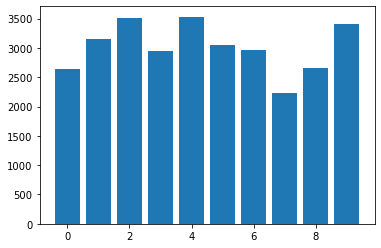

In [127]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.astype(bool).sum())

<BarContainer object of 10 artists>

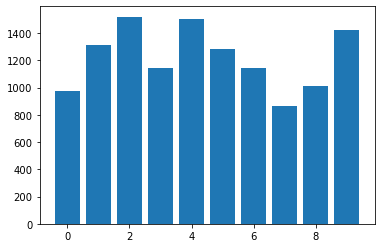

In [128]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.sum())

We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [133]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

label_dicc = {0:"1_muy_introductorio",
1:"2_faltan_explicaciones",
2:"3_poco_preciso",
3:"4_falta_práctica",
4:"5_video_y_audio",
5:"6_dificil_de_seguir",
6:"7_nada",
7:"8_comentario_incomprensible",
8:"9_poco_claro",
9:"10_muy_superficial",
}

In [134]:
df_dominant_topic['Dominant_Topic_number'] = df_dominant_topic['Dominant_Topic_number'].astype('int64')

In [135]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic_number'].map(label_dicc)

df_dominant_topic.to_csv("udemy_reviews_dominant.csv.zip", 
           index=False, 
           compression="zip")

try:
  shutil.copy('udemy_reviews_dominant.csv.zip', udemy_folder + '/udemy_reviews_dominant.csv.zip')
except:
  pass

df_dominant_topic.sample(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic
2802,2802,4,0.72,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","Es bueno pero imagino que se pondra mejor, espero luego pueda dar mejor calificación.",5_video_y_audio
3250,3250,4,0.40,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","Es claro, y espero las promesas de profundización de los temas",5_video_y_audio
366,366,9,0.91,"cosas, explica, explicar, hace, demasiado, basico, rapido, hacer, explicaciones, aprender",En ocasiones va demasiado rápido y hay que devolver el video varias veces para ver los pasos que hizo,10_muy_superficial
347,347,0,0.47,"temas, version, informacion, falta, explicacion, deberia, ejemplos, esperaba, interesante, gustaria","Me parecio que deberia ser mas de desarrollo web utilizando url gratuitas , pero me enseño bastante.",1_muy_introductorio
12398,12398,6,0.66,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto","Buen curso, podrias mejorar en dejar (bueno si es que se puede) el proyecto completo, ya que en algun momento cuando realice todo el proyecto, surgieron varios problemas como de actualizaciones, boostrap, font awesome, etc. y tener realmente el material final, ya que lo tengo pero con varios ""errores"" los cuales tuve que ver varias veces los videos.",7_nada
2911,2911,7,0.53,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux",el contenido esta adecuado a las necesidades de aprendizaje basica en linux.,8_comentario_incomprensible
3541,3541,3,0.46,"falta, conceptos, explica, solo, parte, ejercicios, programacion, basicos, ejemplos, creo","El profesor explica muy bien y todo. pero se me hizo muy corto el curso, seria ideal si añadieran mas ejercicios y mas contenido.",4_falta_práctica
5216,5216,4,0.65,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","En general el curso es malo:\n-Curso es demasiado basico, y no interioriza en nada, basicamente es leer un tutorial de internet.\n-Ejemplos no funcionan bien ni estan bien definidos. \n-Los videos no estan bien preparados, textos a veces no calzan con lo que se habla.\n-Pronunciación en inglés debe mejorar mucho, ya que a veces no se entiende las palabras que usa, ya que en inglés no se pronuncian así (ej engine se pronuncia ÉN-YIN no EN-YÁIN)\n-Diferencias de volumen en el audio entre videos es molesto.\n-Las partes complejas simplemente las pone en un texto sin explicarlas.\n-Falta más trabajo en el los guiones, contenido y coherencia del curso",5_video_y_audio
7638,7638,7,0.57,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux","aparentemente no era lo que esperaba, seguiré avanzando para ver si me involucra más.",8_comentario_incomprensible
845,845,6,0.64,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto",Hasta el momento creo que el curso esta bien explicado; pero existen algunos problemas y no hay como comunicarse con el instructor,7_nada


In [136]:
df_dominant_topic.isna().sum()

Document_No              0
Dominant_Topic_number    0
Topic_Perc_Contrib       0
Keywords                 0
Text                     0
Dominant_Topic           0
dtype: int64

array([<AxesSubplot:title={'center':'Dominant_Topic'}>], dtype=object)

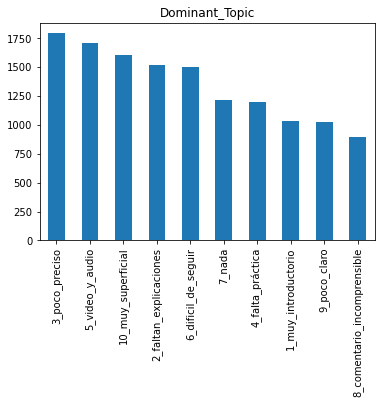

In [137]:
df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar', subplots=True)

In [138]:
% matplotlib inline

topics = df_dominant_topic['Dominant_Topic'].unique()

for topic in topics:
  df_dominant_filtered = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic][["Dominant_Topic","Text"]]
  display(df_dominant_filtered.head(3))
  # Import the wordcloud library
  from wordcloud import WordCloud
  # Join the different processed titles together.
  long_string = ','.join(list([' '.join(map(str, l)) for l in df_dominant_filtered['Text']]))
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=30, contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  wordcloud.to_image()
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


UsageError: Line magic function `%` not found.


In [144]:
df_news['label'] = df_dominant_topic['Dominant_Topic']
df_news['label_id'] = df_dominant_topic['Dominant_Topic_number']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']
df_news["label"].fillna("X",inplace=True)

Let's examine some text and its topics

In [146]:
df_news[['comment', 'label','label_id']].sample(10)

,comment,label,label_id
10564,"Es un curso muy básico, hay algunos conceptos que se podrían explicar con más profundidad.",10_muy_superficial,9
4690,Muy buena explicación de como empezar a emprender dando ejemplo desde un punto de vista diferente a todo lo demás,9_poco_claro,8
8817,"parece que esa improvisando su curso, duda mucho lo que esta diciendo, se repite...",5_video_y_audio,4
299,"Se entregan conceptos estandar, me gustaría algo de las últimas investigaciones y conceptos más modernos orientados a trabajos online",2_faltan_explicaciones,1
7551,"El curso es realmente sencillo de entender pues el profesor explica de una manera fluida y sin aburrir, en tiempos los maneja de forma correcta y dentro de los ejemplos que muestra se explica la gran variedad y diversidad de funciones que se pueden implementar en ionic, así también la integración con otras herramientas.",6_dificil_de_seguir,5
4418,"Solo son un montón de diapositivas una detrás de otra, cualquier web del tema da mas y mejor información. Además va muy lento, ni reproduciéndolo al doble de velocidad va suficientemente rápido, son dos horas y media, pero en realidad a la velocidad correcta no llegaría a media hora. Incluso tiene faltas de ortografía, que es una de las primeras cosas que dice que no hay que tener.",6_dificil_de_seguir,5
2895,"Fue buena pero entendi porque tengo experiencia, si me hubiese tomado este curso sin conocimientos no hubiese entendido esta clase, me parece que primero hay muchas cosas teorias por cubrir sobre tcp ip antes de ir a configurar. Pero igual me parece muy bueno ya que vengo con esos conocimientos",2_faltan_explicaciones,1
616,"Los videos estan con temas cortados, no sigue una linea temoporal haciendo dificil seguir la clase",5_video_y_audio,4
12059,"El sonido es de mala calidad y el locutor, además, se muestra muy dubitativo y no se le entiende con una claridad alta.",5_video_y_audio,4
2470,"No se si es tan bueno usar tanto wizard en nuestras aplicaciones, pero estoy a la espera de continuar mirando los siguiente capítulos, de todas maneras los conceptos los encuentro acertados.",6_dificil_de_seguir,5


In [150]:
for label_id in range(10):
    display(df_news[ df_news['label_id'] == label_id].sort_values(by='label_confidence',ascending=False)[['label_id','label','comment','comment_cleaned']].head(5))

,label_id,label,comment,comment_cleaned
456,0,1_muy_introductorio,"El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.","[profesor, demuestra, conocimiento, pleno, temas, embargo, seria, indique, archivo, usara, cada, clase, principalmente, iniciar, orden]"
1147,0,1_muy_introductorio,"El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.","[cumple, funcion, introductoria, embargo, considero, podria, profundizar, aspectos, lado, datos, trabajar, arcmap, error]"
8999,0,1_muy_introductorio,Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.,"[iniciarse, manejo, framework, embargo, falta, desarrollo, varios, temas, importantes, gestion, sesiones, usuari]"
11040,0,1_muy_introductorio,"la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.","[informacion, bastante, util, embargo, gustaria, prefundisara, ciertos, aspectos, tener, ejemplos, cada, tema, h]"
1072,0,1_muy_introductorio,"La parte macros esta super bien, pero en la parte Visual Basic, comienza a crear lenguaje sin explicar nada","[parte, macros, super, parte, visual, basic, comienza, crear, lenguaje, explic]"


,label_id,label,comment,comment_cleaned
8647,1,2_faltan_explicaciones,"Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.","[explica, ejemplos, proyectos, reales, aplicar, ense, queda, bastante, cojo, explica, justify, content, haga, mini, proyecto, aplica, concepto, pagina, real, luego, propiedad, flex, dice, omite, propiedad, flex, shrink, valor, defecto, flex, shrink, elemento, hijo, queda, igual, modificacion, ancho, element]"
12469,1,2_faltan_explicaciones,"Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.","[explicacion, iniciarse, mundo, diria, mejor, forma, hacerlo, complementa, html, mismo, navis, code, solo, agregar, gustado, seccion, explicar, brevemente, significa, cada, propiedad, utilizada, largo, tutorial, marcha, haga, didactico, avance, proyectos, demas, dec]"
364,1,2_faltan_explicaciones,"Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad ni se parecen a las del examen real. Como no se actualice este curso es poco útil para el examen actual. Cierto es que las preguntas de ejemplo que vienen con el programa oficial tampoco se parecen al examen actual. Hay algo que no se ha actualizado debidamente","[desastre, sacado, varias, veces, preguntas, pruebas, hora, verdad, parecen, examen, real, actualice, util, examen, actual, cierto, preguntas, ejemplo, vienen, programa, oficial, tampoco, parecen, examen, actual, actualizado, debid]"
13372,1,2_faltan_explicaciones,"Me sabe mal, pero esto es un curso para enseñar a un alumno y no para ver todo lo tu sabes, que es mucho. Primero, no me ha gustado que saques todos los errores en modo desarrollo. Luego, he encontrado algun corte de video, con alguna modificación de código, sin poder ver o saber el porque se ha hecho (ej. token en base de datos)\nSaludos","[sabe, ense, alumno, sabes, primero, gustado, saques, errores, modo, desarrollo, luego, encontrado, algun, corte, video, alguna, modificacion, codigo, poder, saber, hecho, token, base, datos, salud]"
8037,1,2_faltan_explicaciones,"Falta librerías (por ejemplo socket que se usa mucho para scripts); explicar qué significa cada objeto en inglés para que no se aprenda de memoria y se entienda qué significa (no sólo para qué sirve), por ejemplo len(gth).\nComo primera parte o introducción al lenguaje está bien, lejos de experto.","[falta, librerias, ejemplo, socket, scripts, explicar, significa, cada, objeto, ingles, aprenda, memoria, entienda, significa, solo, sirve, ejemplo, primera, parte, introduccion, lenguaje, lejos, expert]"


,label_id,label,comment,comment_cleaned
12304,2,3_poco_preciso,"Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde ""explica"" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir","[alguien, empezando, programacion, desactualizado, video, relacion, butterknife, suplantado, viewbinding, llegar, video, explica, tratar, cambio, complicado, igual, forma, video, explica, iniciar, viewbinding, creo, seria, video, correcto, debe, redirig]"
13117,2,3_poco_preciso,"Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: ""Mi primera aplicación con Android (Primeros pasos)"". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API's y la elección de estás.","[realmente, ayudo, titulo, queda, demasiado, grande, nombre, pondria, seria, primera, aplicacion, android, primeros, pasos, mostrar, android, novedad, demasiado, explican, importancia, eleccion]"
1869,2,3_poco_preciso,"seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.","[seria, mejor, explicacion, adquirir, ciertos, dispositivos, terminos, terminologia, usada, dispositivos, exactamente, acceso, dispositivo, podemos, poner, practica, aprend]"
10102,2,3_poco_preciso,"Cumplió con mis expectativas de aprender los fundamentos básicos, pero al intentar realizar la practica; en el último caso no lo logré debido a no entender la instalación de los programas necesarios.","[cumplio, expectativas, aprender, fundamentos, basicos, intentar, realizar, practica, ultimo, caso, logre, debido, entender, instalacion, programas, necesari]"
13101,2,3_poco_preciso,SALUDOS DESDE URUGUAY ENSEÑAS BIEN PERO CREO PODRIAS PONERLE UN POCO MAS CONTENIDO.... UNA APP QUE SIRBA DE ALGO. SOLO APRENDIMOS CONCEPTOS BACICOS PERO EN REALIDAD NOS QUEDAMOS EN CERO... PORQUE CON ESTO NO CREAMOS UNA APP QUE PUEDAMOS UTILIZAR PARA ALGO CREO ES DEMACIADO BACISO QUE SI LE PONES ALGO MAS PODRIA UNO ENRUCIASMARCE A COMPRAR UN CURSO PERO CON ESTO UNO NO SABE LO QUE TIENES PARA ENTREGAR,"[saludos, uruguay, ense, creo, podrias, ponerle, contenido, sirba, solo, aprendimos, conceptos, bacicos, realidad, quedamos, cero, creamos, puedamos, utilizar, creo, demaciado, baciso, pones, podria, enruciasmarce, comprar, sabe, entreg]"


,label_id,label,comment,comment_cleaned
604,3,4_falta_práctica,"Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su ""trabajo"".","[siento, bastante, desactualizado, respecta, herramientas, utilizan, hacking, estan, obsoletas, cambiaron, terminos, licencia, pueden, explotar, respecta, teoria, aclara, bastante, panorama, trabajan, hackers, hacen, llevar, cabo, trabaj]"
2352,3,4_falta_práctica,Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas,"[llego, punto, test, perfecto, buena, refactorizacion, trucos, explicacion, implementar, test, nula, entiendo, primer, test, endpoint, hecho, sabemos, hacer, jest, idea, explicando, todas, form]"
9551,3,4_falta_práctica,"Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo","[oferta, gratis, llamo, atencion, principio, pense, seria, mejorar, carrera, profesional, trata, educa, desarrollar, actividad, laboral, cuidando, salud, recomiendo, hecho, pesado, creo, cursillo, util, valoramos, minimo, pabl]"
4413,3,4_falta_práctica,"Esperaba un poco más del curso, no se aprende nada en detalle, solamente es un repaso de cada componente de la documentación y luego una aplicación muy básica donde no se explica de forma técnica cada cosa que se hace.","[esperaba, aprende, detalle, solamente, repaso, cada, componente, documentacion, luego, aplicacion, basica, explica, forma, tecnica, cada, cosa, hac]"
8896,3,4_falta_práctica,"Está bien como explica la base del Mindfullness, pero es bastante insuficiente a la hora de explicar como lograr hábitos saludables que una persona pretenda en su vida. Las técnicas que comenta son para aplicar Mindfullness, pero no para incorporar e implementar nuevos hábitos en la persona.","[explica, base, mindfullness, bastante, insuficiente, hora, explicar, lograr, habitos, saludables, persona, pretenda, vida, tecnicas, comenta, aplicar, mindfullness, incorporar, implementar, nuevos, habitos, person]"


,label_id,label,comment,comment_cleaned
5431,4,5_video_y_audio,"Falta mas seriedad del instructor, dice mucho "" eh, eh, eh, perdon, eh, eh, perdon."" no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.","[falta, seriedad, instructor, dice, perdon, perdon, seguro, mismo, demuestra, duda, falta, conocimiento, ademas, fuente, informacion, wikipedia, fuente, dudosa, cualquiera, puede, editar, agregar, cualquier, cosa, debe, fuente, confiable, wikipedia, puede, fuente, informacion, dice, seri]"
3356,4,5_video_y_audio,"Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una ""muletilla"" deseperante que esta en la mayoría de las lecciones que vi, es un ""ehh, ehh, ehh"" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.","[estaria, mejor, sido, subtitulado, peliculas, instructor, pesar, intenciones, pierde, explicaciones, creo, hace, largos, videos, realidad, deberian, tenia, guion, preparado, deriva, instructor, muletilla, deseperante, mayoria, lecciones, pensara, decir, ademas, juro, escuche, ladrar, perros, personas, hablaban, fond]"
13498,4,5_video_y_audio,"Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la plataforma ideal, aquí se viene a tomar cursos y a aprender no a ver publicidad de Solange Candelo y su empresa Realtaria, tiene poca información útil como curso pero las partes en las que los agentes inmobiliarios hablan de por qué Realtaria es una buena empresa no me interesa en lo absoluto, deberian quitarlo, en fin, no me puedo quejar ya que la poca información pues es gratis.","[definitivamente, recopilacion, videos, youtube, seguro, udemy, plataforma, ideal, aqui, viene, tomar, aprender, publicidad, solange, candelo, empresa, realtaria, poca, informacion, util, partes, agentes, inmobiliarios, hablan, realtaria, empresa, interesa, absoluto, deberian, quitarlo, puedo, quejar, poca, informacion, pues, gratis]"
13465,4,5_video_y_audio,"Lo bueno, si es gratis mejor. El problema es que este curso es más como regular, pero lo gratis lo hace atractivo. Es básicamente el tutorial de NestJS narrado en un español en donde el inglés brilla totalmente por su ausencia, para bien o para mal. La verdad, nada que seguir la documentación no te pueda dar.\n\nLa explicación de Postman es un plus para las personas que no saben nada de la herramienta.","[gratis, mejor, problema, regular, gratis, hace, atractivo, basicamente, tutorial, nestjs, narrado, espa, ingles, brilla, totalmente, ausencia, verdad, seguir, documentacion, pueda, explicacion, postman, plus, personas, saben, herramient]"
13050,4,5_video_y_audio,"Los videos son muy interesantes, sin embargo los cuestionarios al final de cada módulo son frustrantes porque hacen alusión a temáticas que no se tocaron en los videos. Dado que esas temáticas son parte de las preguntas imagino deben ser importantes por lo que da la impresión que el curso no está completo, sino que le faltan videos.","[videos, interesantes, embargo, cuestionarios, final, cada, modulo, frustrantes, hacen, alusion, tematicas, tocaron, videos, dado, tematicas, parte, preguntas, imagino, deben, importantes, impresion, completo, sino, faltan, vide]"


,label_id,label,comment,comment_cleaned
9152,5,6_dificil_de_seguir,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho","[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, tercer, ...]"
387,5,6_dificil_de_seguir,"Comparada con los cursos de Logali, este da la impresión de estar menos preparado, trata de explicar los temas pero tiene que ir resolviendo incidentes conforme se desarrolla el curso. Es bueno, pero muy corto; para la amplia gama de cosas nuevas del abap 7.4 esta muy limitado. Además, insisto, si se tiene la referencia de los cursos de Logali, a este le falta mas forma y estructura. Revisen el curso de POO ABAP de Logali, diapositivas animadas, curso preparado de inicio a fin, ejemplos claro, precisos y sin error. La verdad, estoy muy decepcionado de lo que pague.","[comparada, logali, impresion, menos, preparado, trata, explicar, temas, resolviendo, incidentes, conforme, desarrolla, corto, amplia, gama, cosas, nuevas, abap, limitado, ademas, insisto, referencia, logali, falta, forma, estructura, revisen, abap, logali, diapositivas, animadas, preparado, inicio, ejemplos, claro, precisos, error, verdad, decepcionado, pag]"
2091,5,6_dificil_de_seguir,"Quiero agradecer por tan valiosa información, en mi caso el Estudio del idioma Ingles no se meda de forma natural y fácil, pero ahora que escucho la profesora ANNA me trasmitió tanta pasión y positivismo que estoy deseosa de iniciar y poder llegar al final con muy buenos resultados.\nGracias prof

,label_id,label,comment,comment_cleaned
1149,6,7_nada,"empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.","[empezando, llama, matricule, crea, confianza, matricule, teledeteccion, pesar, temario, pueda, compartido, incluso, igual, haciendo, llama, ultimos, modulos, visto, iguales, duran, minutos, tras, repetir, mismo, inicio, final, queda, minuto, video, cuya, metodologia, repite, combinaciones, bandas, interpretacion, puede, exponer, manera, aprovechable, alumn]"
3078,6,7_nada,"Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.","[explicaciones, claras, embargo, creo, alcance, puede, hacer, informacion, limitado, ejemplo, unicamente, mercancias, livianas, proveedores, manejen, solo, mediante, transporte, aereo, mejor, diganme, solo, puedo, importar, funk]"
9241,6,7_nada,"al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva a la misma página, ofreciendo otro tipo de información del día y no sobre el artículo donde informa la creación de la emisora de radio","[ingresar, primer, modulo, indica, leer, articulo, pagina, periodico, colombia, pues, vinculo, existe, lleva, misma, pagina, ofreciendo, tipo, informacion, articulo, informa, creacion, emisora, radi]"
12408,6,7_nada,"no responde a las preguntas que se realizan. El curso no esta actualizado y al descargar los recursos, varia totalmente a lo que dicta la clase, la cual genera confusion y desgano en continuar con el mismo ya que no se puede avanzar.","[responde, preguntas, realizan, actualizado, descargar, varia, totalmente, dicta, clase, genera, confusion, desgano, continuar, mismo, puede, avanz]"
44,6,7_nada,"La verdad en el tema 5 minuto 14 aproximadamente esta mal editado, incluso la facilitadora dice una mala palabra debieron haber editado bien este video. Por favor tomen esto como algo constructivo. Gracias","[verdad, tema, minuto, aproximadamente, editado, incluso, facilitadora, dice, mala, palabra, debieron, haber, editado, video, favor, tomen, construct]"


,label_id,label,comment,comment_cleaned
9788,7,8_comentario_incomprensible,"So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.","[been, very, enjoyable, like, understand, that, this, introductory, consists, summary, which, turn, consists, some, videos, other, same, author, however, annoying, that, alludes, videos, that, part, this, particularly, when, talks, about, video, about, sharpening, formones, that, included, this, other, hand, final, video, finishes, nothing, only, justification, find, inclusion, this, because, promotes, some, more, advanced, work, rest, reaffirm, what, said, beginning]"
6862,7,8_comentario_incomprensible,"I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.","[like, honest, with, friend, think, have, right, idea, implemented, need, repeat, words, during, video, because, monotonous, think, could, simulate, situations, real, life, more, interesting, great, project]"
745,7,8_comentario_incomprensible,"Things to improve: \n-Some times (not many) the pronunciation of the words in Spanish is not correct and this could cause some confusion.\n-The practices appear before the explanation.\n-All assignments are the same, so it makes them a little boring. Try to vary the assignments.\n\nGood things:\n- The explanations are good\n- The material is good\n- Cases of study are great examples of how all this works and it also helps to understand that even though, Scrum@Scale defines some concepts and names to some roles, ceremonies and/or teams, it is also very flexible and can work with some little differences.\n-","[things, improve, some, times, many, pronunciation, words, spanish, correct, this, could, cause, some, confusion, practices, appear, before, explanation, assignments, same, makes, them, little, boring, vary, assignments, things, explanations, material, cases, study, great, examples, this, works, also, helps, understand, that, even, though, scrum, scale, defines, some, concepts, names, some, roles, ceremonies, teams, also, very, flexible, work, with, some, little, differenc]"
4861,7,8_comentario_incomprensible,"I think that He was more focus in Linux that docker, even though Linux is important, I hope a bit more regarding docker. more practices case!, thank u","[think, that, more, focus, linux, that, docker, even, though, linux, important, hope, more, regarding, docker, more, practices, case, thank]"
2918,7,8_comentario_incomprensible,"I hope the Tests that are provided by this course be more accurate, they have questions to long answers, the course could provide that answers without need to investigate them.","[hope, tests, that, provided, this, more, accurate, they, have, questions, long, answers, could, provide, that, answers, without, need, investigate, them]"


,label_id,label,comment,comment_cleaned
8176,8,9_poco_claro,"En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.","[primer, lugar, parece, util, traza, lineas, marketing, online, embargo, considero, explicaciones, quedan, faltas, contenido, ejemplos, casos, pobres, expresiones, utilizadas, faciles, comprender, pesar, salud]"
2051,8,9_poco_claro,"Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso","[desmotivante, tutor, hace, varios, meses, responde, inquietudes, alumnos, explicaciones, demasiado, cortas, explica, manejo, futuros, referente, psicotrading, deja, desear, realmente, tenia, mejor, expect]"
9290,8,9_poco_claro,"La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso ""basico"" y se mueve demasiado rapidamente con el cursor dando ""por hecho"" muchos aspectos que no los son para un principiante","[explicacion, veces, clara, debido, forma, expresarse, docente, ademas, habla, demasiado, rapido, basico, mueve, demasiado, rapidamente, dando, hecho, aspectos, principi]"
743,8,9_poco_claro,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale","[contenido, claro, interesante, tomado, fabian, sido, mucha, utilidad, encontre, deficiencias, material, apoyo, seccion, lanzamiento, clara, general, adquiere, gran, conocimiento, scrum, scal]"
454,8,9_poco_claro,"Si es bueno, pero estaría bien profundizar un poco en el cómo se hace. Todos los tips de automatizar respuestas, etc... algo así por el estilo. Hace falta más ilustraciones , videos explicativos, ejemplo en concreto, casos de éxito.","[estaria, profundizar, hace, tips, automatizar, respuestas, estilo, hace, falta, ilustraciones, videos, explicativos, ejemplo, concreto, casos, exit]"


,label_id,label,comment,comment_cleaned
8706,9,10_muy_superficial,"El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.","[iniciarse, unity, echarle, tarde, viendo, funcionalidades, basicas, incompleto, haces, dise, nivel, moneda, casa, quieres, hacer, juego, final, hacer, pago, digo, inutil, hacer, nunca, tocado, unity, sacas, idea, superficial, funcion]"
2457,9,10_muy_superficial,"Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.","[empezar, aprendes, varias, cosas, completo, explica, varios, temas, importantes, verdad, dedica, crear, proyectos, explicar, creo, framework, recomiendo, persona, iniciando, desarrollo, caso, creo, vallas, aprender, nuev]"
8724,9,10_muy_superficial,El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interactuar con la herramienta.,"[titula, primer, juego, unity, pense, realizar, juego, completo, solo, dise, todas, formas, gusto, gratuito, pues, primera, toco, unity, ayudo, hora, interactuar, herramient]"
2546,9,10_muy_superficial,"He descubierto bastante características nuevas que me han hecho profundizar o me han animado a profundizar más en mis conocimientos de Javascript.\n\nNo obstante, esperaba algo un poco más avanzado.\n\nEl instructor se nota que sabe de lo que habla, pero a ratos resulta un poco lento y repetitivo.","[descubierto, bastante, caracteristicas, nuevas, hecho, profundizar, animado, profundizar, conocimientos, javascript, obstante, esperaba, avanzado, instructor, nota, sabe, habla, ratos, resulta, lento, repetit]"
13281,9,10_muy_superficial,"Ah sido un curso muy bueno, aprendí buenas practicas las cuales me ayudaran mucho en mis proyectos, me gustaría que el curso fuese más extenso, pero vamos no puedo pedir mucho de un curso gratuito, mas sin embargo a sido un excelente curso.\nEl instructor es muy claro y se nota que posee conocimientos avanzados en sql","[sido, aprendi, practicas, cuales, ayudaran, proyectos, gustaria, extenso, vamos, puedo, pedir, gratuito, embargo, sido, instructor, claro, nota, posee, conocimientos, avanz]"


### let's see the distribution of topics


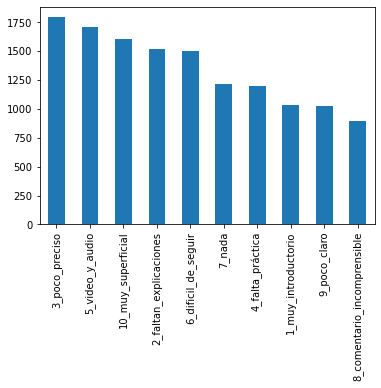

In [151]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

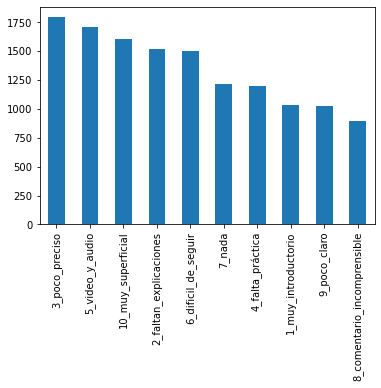

In [152]:
ax = df_news['labels'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [153]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [154]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
5      0.07  0.01       1        1 13.27
2     -0.04  0.02       2        1 12.64
1      0.00  0.02       3        1 12.30
4      0.12  0.09       4        1 11.47
9      0.05  0.03       5        1 11.36
6      0.14  0.03       6        1  9.96
3     -0.07  0.00       7        1  8.78
8     -0.03  0.02       8        1  7.26
0     -0.24  0.07       9        1  6.85
7     -0.00 -0.28      10        1  6.11, topic_info=            Term     Freq    Total Category  logprob  loglift
139        cosas 1,161.00 1,161.00  Default    30.00    30.00
552        audio   460.00   460.00  Default    29.00    29.00
78        videos 1,170.00 1,170.00  Default    28.00    28.00
16      explicar   744.00   744.00  Default    27.00    27.00
599    conceptos   744.00   744.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
142  explicacion    50.97   827.31  Topic10    -5.25     0.01
78        videos    51.19 1,170.25  Topic10    -5.24    -0.34
23          tema    45.39   780.98  Topic10    -5.36    -0.05
210        poder    42.62   435.22  Topic10    -5.43     0.47
150        video    42.26   941.06  Topic10    -5.43    -0.31

[801 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3463      9  0.92  abordan
3132     10  0.96    about
535       1  0.05    aburr
535       8  0.73    aburr
535      10  0.18    aburr
...     ...   ...      ...
151       4  0.07  youtube
151       5  0.23  youtube
151       6  0.34  youtube
151       8  0.01  youtube
151      10  0.01  youtube

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 10, 7, 4, 9, 1, 8])

In [155]:
len(df_news),df_news.isna().sum()

(13509,
 index               0
 id                  0
 course              0
 rating              0
 comment             0
 user                0
 tag                 0
 comment_cleaned     0
 labels              0
 label_confidence    0
 label               0
 label_id            0
 dtype: int64)

In [156]:
# NOW.... GROUP BY COURSE
# AND GROUP BY LABEL THEN

In [169]:
df_by_course = df_news.groupby("course")
df_agg_by_course = pd.DataFrame(index=df_news["course"].unique())

In [170]:
df_agg_by_course["comments"] = df_by_course['comment_cleaned'].agg(sum)
df_agg_by_course.sample(10)

,comments
1738484,"[irregular, nivel, inmersion, creo, atina, infografia, instrucciones, incluso, ajenas, valores, trabajo, workshop, concentra, trabajo, ejemplo, privilegia, estetica, toca, cuestiones, dise, informacion, sirve, caso, estudio, interesa, didactica, aplicada, infografia, demas, parece, fall]"
1591590,"[actualizado, sale, totalmente, diferente, podemos, hacer, pid, video, demasiado, largo, explica, punto, requiere, tanta, ejemplificacion, experiencia, desactualizado, referido, google, social, ex, datos, interesantes, actualizarlo, google, disponible, falto, instagram, complement, principal, social, instagram, cambio, google, ex, creacion, gmail, paso, basico, actualidad, mayor, parte, personas, saben, hacerlo, espero, modulos, informacion, interes, crear, cuenta, correo, hace, informacion, relevante, mucha, paj, video, minutos, abrir, cuenta, gmail, desperdicio, tiempo, igual, video, buscar, terminos, maneras, buscar, terminos, populares, mencion]"
1636756,"[esperaba, pense, hablaria, aspectos, graficos, programas, sbastante, teor, sido, fluido, contenido, interesante, explicaciones, cl, eleccion, obstante, agradece, esfuerzo, instructor, problema, maestro, hablaba, bastante, rapido, tenia, regresar, video, varias, veces, entender, anotar, explicacion, iniciar, trae, informacion, parte, texturas, video, minuto, menciona, mate, grises, obscuros, liso, mapa, claro, examen, respuesta, contrari, realmente, interesado, continuar, tomando, visto, aqui, animado, continuar, aprendiendo, conocer, interesantismo, mundo, model, introduccion, mundo, presentacion, podia, haber, resumido, pagina, blog, capitulo, hardware, espere, casi, solo, encontre, pagina, blanco, comenzar, mundillo, decepciono, dem]"
2607088,"[esperaria, propia, experiencia, indicadores, importantes, considerar, ventajas, desventajas, cada, plataforma, explic, eleccion, solo, audio, escuchaba, fuert, bueno, dominio, tema, audio, bajo, unica, quej]"
737538,"[solo, enfoca, consecuencias, tecnicas, escencia, or, eleccion, charlatan, compre, vendermel, parece, interesante, informacion, demas, explicada, solo, cuesta, aplicarlo, manera, practica, creo, poder, aplicar, comprender, hace, falta, retomarlo, vec, flojo, flojo, unico, tema, queda, floj]"
602044,"[intenciones, basico, empezar, falta, actualizarse, conveniente, tutor, claro, momento, expl, preciso, cuanto, tema, cuestion, falta, mayor, informacion, respecto, ademas, demasiado, parsimonioso, hablar, determinados, momentos, vuelve, tedi, excesivamente, basico, ritmo, clases, demasiado, lento, hecha, falta, agilidad, soltura, general, solo, recomiendo, personas, ningun, conocimiento, unity]"
814594,"[interesante, opinion, autor, perdio, tiempo, observaciones, solo, decirlas, rapido, sencillo, entender, video, esperar, escrib, exlpicado, lento, personas, nuevas, bastante, sencillo, deja, quiera, aprender, gratuito, exig, monotono, emplea, aprendiendo, ninguna, pagina, basica, puedan, viendo, result, conoce, tema, aplica, mejores, pract, aprender, basico, embargo, practica, explica, hace, cosas, queda, investigar, cuenta, copiar, exactamente, hace, iniciar, recomendari, gratis, profesor, profesional, momento, imparte, muestra, conocimiento, comprare, impart, momento, html, menciona, insertar, etiquetas, atributos, menciona, justifica, aporta, grandes, razones, usarlos, creo, videos, sabes, temas, secuencia, temas, embargo, aporta, respecto, cualquier, pagina, diga, insertar, etiquet, apenas, pruebo, habria, cosas, mejorar, audio, comunicacion, ense, tenho, conhecimento, algum, ...]"
2534680,"[esperaba, introducirte, mundo, docker, buuen, nombre, dice, ofrece, mismo, temas, importantes, compose, formacion, exijo, devolucion, dinero, cambiarle, nombre, nociones, basicas, dock, basico, iniciarse, docker, pasa, sabes, absolutamente, docker, recomendable, realizarlo, aprovechando, ofertas, lanza, udemy, aprendi, siento, falto, superficial, comandos, subcomandos, aprendiendo, cuenta, documentacion, oficial, base,

In [171]:
df_agg_by_course["labels_list"] = df_by_course['label'].apply(list)
df_agg_by_course.sample(10)

,comments,labels_list
2346850,"[creacion, troncales, clarosip, altice, video, corto, configuracion, troncal, aparte, dice, dejar, encontre, ningun, lado, musica, fondo, desesper, desordenado, genera, expectativas, luego, concret, secciones, importantes, estan, explicadas, saltan, partes, secciones, relevantes, extiende, explicacion]","[2_faltan_explicaciones, 3_poco_preciso, 5_video_y_audio]"
2087404,"[claudio, ense, ando, debe, mejorar, dotes, hablar, escribir, ameno, debe, arreglar, desarrollo, ejercicio, seccion, sqldeveloper, pone, funciona, descargarlo, adecuadamente, nociones, generales, explicadas, queda, corto, ejemplo, parte, datamodeler, seria, gran, ayuda, incluir, ejemplos, ejercici]",[2_faltan_explicaciones]
2898700,"[superficial, revisa, fondo, ningun, proceso, produccion, esperaba, titulo, casi, refiere, proceso, audiovisual]",[6_dificil_de_seguir]
900338,"[momento, entrando, echo, falta, ejemplo, hablar, alphas, primera, leve, explicacion, dem, eleccion, gustaria, fluidez, paradas, largas, aprovechar, timelapses, acciones, larg, problemas, zbrush, herramientas, optimo, causan, errores, aqui, tratan, errores, darles, soluciones, hace, encuentras, solucion, quedes, bloqueado, poder, avanzar, preferiria, empezar, modelar, modelo, trataran, herramientas, usar, mano, modelo, viesen, pros, contras, cada, herramienta, error, explica, fondo, errores, clase, sigue, acabas, perdiendote, parando, cl, material, brinda, profundiza, cada, tema, zbrush, instructor, favor, intente, explicar, didactico, verdad, cuesta, muchisimo, seguir, hilo, entender, cada, tema, llevar, pract, momento, lecciones, parece, pongo, estrellas, aprendiendo, interfaz, momento, pincha, aqui, alla, espero, adelante, convierta, explicacion, detallada, ques, ...]","[9_poco_claro, 1_muy_introductorio, 2_faltan_explicaciones, 3_poco_preciso, 6_dificil_de_seguir, 6_dificil_de_seguir, 10_muy_superficial, 10_muy_superficial, 7_nada, 3_poco_preciso, 2_faltan_explicaciones]"
442170,"[ningun, enlace, obtener, listas, materiales, kits, funciona, recomiendo, absoluto, compr, rapido, apuntes, practico, demostrativo, educacional, funcionan, enlac, videos, excesivamente, cortos, plano, soldar, piezas, tarjetas, listado, material, existe, tienda, digital, sirv, primer, lugar, deberian, actualizar, contenido, basico, falta, listado, materiales, creo, pueden, monetizar, distribuidores, distint, hace, planos, medios, quizas, demasiado, rapidos, cuales, aprecian, detalles, videos, general, quedan, escasos, explicacion, planos, cortos, distintas, perspectivas, adirian, claridad, locucion, demasiado, concisa, organizacion, videos, permite, rapidamente, punto, interesa, video, explica, controladora, componentes, qued, faltan, pasos, etapa, construccion, drone, esperaba, instrucciones, conectar, cosa, forma, detalla, planos, cerrados, videos, guia, videos, youtube, detall]","[9_poco_claro, 9_poco_claro, 3_poco_preciso, 5_video_y_audio, 10_muy_superficial, 10_muy_superficial]"
2772048,"[contenido, valioso, video, problemas, calidad, llama, sana, intestinos, dias, dietas, parecer, sugerencia, seguir, ningun, plan, gusta, deberia, implementar, planes, procesos, nuevos, habitos, cronogramas, quedo, cort]",[5_video_y_audio]
1096866,"[veces, demasiado, repetitivo, cosas, explicado, unas, cuantas, veces, sabia, programa, ingles, hace, pesado, mezcla, espa, ingles, caso, ejemplo, tener, programa, espa, intentar, crearme, apuntes, recurrir, perdi, tiempo, mezcla, idiomas, sido, util, habia, practicado, parte, indesign, quedado, corto, ciertos, aspectos, extenso, repetir, cosas, estaria, perfecto, todas, formas, marlon, falta, parte, practica, ejercicios, resuelve, instructor, aprender, resto, diferencia, mismo, autor, slides, cada, tema, desarrollar, vendr, puedo, previsualizacion, interactiva, ordenador, antigu, persona, necesita, motivar, continuar, inspira, saber, mismo, instruir, empieza, monotono, puede, obviar, comprador, quiere, ejecutar, caso, interact, siento, aspectos, pod

In [177]:
df_agg_by_course['labels_len'] = df_agg_by_course['labels_list'].str.len()

In [179]:
df_agg_by_course.sort_values('labels_len', ascending=False).head(10)

,comments,labels_list,labels_len
1436088,"[siento, faltan, cosas, explicar, tocan, tem, conceptos, claros, ejemplos, podria, organizado, conten, contenido, introduccion, valor, deseo, crezcas, profesor, lastima, configuracion, terminal, deja, datos, dem, parece, gratuito, cumple, espectativa, basica, parece, falta, propiedad, tema, profesor, ademas, bastante, fatal, herramienta, explicacion, terminal, comandos, fuente, realmente, ilegible, hacia, dificil, porder, observar, contecto, completo, ense, hermano, chanta, podes, tener, whatsap, abiert, disparejo, relacion, orden, ademas, pruebas, campo, reales, github, datos, interesantes, practic, cometidos, varios, errores, iniciar, carpeta, luego, cortarla, pegarla, ubicacion, diferente, realizar, roto, enlace, explicas, repararlo, luego, eliminas, archivo, explicas, recupera, estructurado, realmente, terminado, explicas, mejorar, estructura, explicar, c, audio, explica, temas, estan, ...]","[9_poco_claro, 3_poco_preciso, 1_muy_introductorio, 9_poco_claro, 9_poco_claro, 9_poco_claro, 9_poco_claro, 2_faltan_explicaciones, 2_faltan_explicaciones, 10_muy_superficial, 2_faltan_explicaciones, 6_dificil_de_seguir, 3_poco_preciso, 10_muy_superficial, 6_dificil_de_seguir, 10_muy_superficial, 3_poco_preciso, 9_poco_claro, 10_muy_superficial, 6_dificil_de_seguir, 9_poco_claro, 4_falta_práctica, 2_faltan_explicaciones, 6_dificil_de_seguir, 2_faltan_explicaciones, 3_poco_preciso, 3_poco_preciso, 4_falta_práctica, 8_comentario_incomprensible, 7_nada, 9_poco_claro, 5_video_y_audio, 5_video_y_audio, 9_poco_claro, 5_video_y_audio, 10_muy_superficial, 9_poco_claro, 3_poco_preciso, 7_nada, 1_muy_introductorio, 7_nada, 6_dificil_de_seguir, 2_faltan_explicaciones, 4_falta_práctica, 5_video_y_audio, 9_poco_claro, 6_dificil_de_seguir, 6_dificil_de_seguir, 9_poco_claro, 4_falta_práctica, 4_falta_práctica, 1_muy_introductorio, 5_video_y_audio, 10_muy_superficial, 2_faltan_explicaciones, 7_nada, 7_nada, 6_dificil_de_seguir, 10_muy_superficial, 2_faltan_explicaciones, 6_dificil_de_seguir, 3_poco_preciso, 10_muy_superficial, 10_muy_superficial, 9_poco_claro, 5_video_y_audio, 10_muy_superficial, 2_faltan_explicaciones, 3_poco_preciso, 2_faltan_explicaciones, 2_faltan_explicaciones, 7_nada, 10_muy_superficial, 3_poco_preciso, 10_muy_superficial, 9_poco_claro, 9_poco_claro, 5_video_y_audio, 6_dificil_de_seguir, 10_muy_superficial, 9_poco_claro, 3_poco_preciso, 2_faltan_explicaciones, 10_muy_superficial, 10_muy_superficial, 2_faltan_explicaciones, 5_video_y_audio, 10_muy_superficial, 8_comentario_incomprensible, 9_poco_claro, 5_video_y_audio, 3_poco_preciso, 10_muy_superficial, 7_nada, 10_muy_superficial, 10_muy_superficial, 6_dificil_de_seguir, 10_muy_superficial, 4_falta_práctica, 8_comentario_incomprensible, ...]",113
1671664,"[cuenta, gratuito, cumple, objetivo, debe, recalcar, nombran, variables, tipos, forma, declararlas, adecuadamente, cualquier, modo, sirvio, aprendi, utilizar, adecuadamente, modulo, cl, siento, inconforme, indica, cero, entiendo, faltan, cosas, detalles, explicar, incompleto, youtube, buscar, mejor, darse, idea, funciona, comandos, explica, sirv, batallaba, muchisimo, entender, instructor, coincidia, cosas, decia, escribia, intentaba, interpretar, logre, recolectar, informacion, necesaria, cuestiones, conocia, realmente, basico, funciona, organizacion, temas, decepcionante, hora, entenderlo, aplicar, analiz, profesor, pronuncia, espa, cuesta, entend, estructura, deficiente, profesor, comunica, manera, flu, ense, basico, persona, confusa, explic, iniciar, macros, excel, buena, eleccion, perspectiva, modesta, abordaron, temas, importantes, funciones, basico, intermedias, aplicar, macr, comenzaria, describir, comandos, usuales, ...]","[2_faltan_explicaciones, 10_muy_superficial, 2_faltan_explicaciones, 10_muy_superficial, 5_video_y_audio, 2_faltan_explicaciones, 3_poco_preciso, 1_muy_introductorio, 3_poco_preciso, 2_faltan_explicaciones, 3_poco_preciso, 4_falta_práctica, 8_comentario_inco

In [160]:
df_agg_by_course.to_csv("udemy_reviews_aggregated.csv.zip", 
           index=False, 
           compression="zip")

try:
    shutil.copy('udemy_reviews_aggregated.csv.zip', udemy_folder + '/udemy_reviews_aggregated.csv.zip')
except:
    pass

In [ ]:
labels_expanded = df_agg_by_course["labels_list"].apply(pd.Series)


In [232]:
df_agg_by_course["labels_list"].head()

1640654                                                                                            [8_comentario_incomprensible]
88380                                                                                          [5_video_y_audio, 3_poco_preciso]
126128                                                                                                            [9_poco_claro]
2307340    [6_dificil_de_seguir, 7_nada, 7_nada, 1_muy_introductorio, 3_poco_preciso, 6_dificil_de_seguir, 9_poco_claro, 7_nada]
3517622                                                                                                       [4_falta_práctica]
Name: labels_list, dtype: object

,10_muy_superficial,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro
1317138,11,10,1,10,6,7,4,3,3,7
2258224,3,10,5,17,10,3,3,5,1,5
405252,9,9,3,8,5,2,3,5,6,0
948830,5,9,5,2,6,3,8,10,5,6
935680,4,9,14,6,7,5,6,6,4,3


,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro,10_muy_superficial
1_muy_introductorio,155.68,37.70,54.90,71.13,43.68,52.39,55.15,44.16,36.35,37.55
2_faltan_explicaciones,37.70,91.23,39.12,46.69,30.40,35.80,34.74,29.21,22.91,26.24
3_poco_preciso,54.90,39.12,148.30,57.81,44.45,53.74,52.80,43.51,32.57,37.88
4_falta_práctica,71.13,46.69,57.81,188.78,52.58,64.83,65.13,47.34,37.11,44.65
5_video_y_audio,43.68,30.40,44.45,52.58,116.60,42.24,37.98,35.55,25.51,30.18
6_dificil_de_seguir,52.39,35.80,53.74,64.83,42.24,171.59,59.54,43.42,37.40,33.53
7_nada,55.15,34.74,52.80,65.13,37.98,59.54,147.32,42.19,33.07,36.71
8_comentario_incomprensible,44.16,29.21,43.51,47.34,35.55,43.42,42.19,112.11,26.36,29.22
9_poco_claro,36.35,22.91,32.57,37.11,25.51,37.40,33.07,26.36,83.78,23.30
10_muy_superficial,37.55,26.24,37.88,44.65,30.18,33.53,36.71,29.22,23.30,91.59


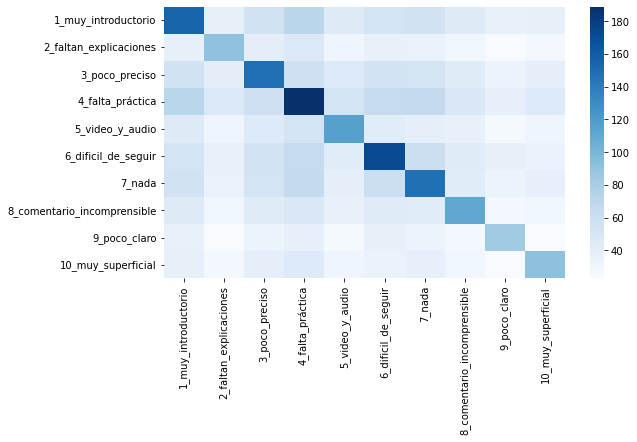

In [296]:
import itertools
import numpy as np

class MultiLabelCounter():
    def __init__(self, classes=None):
        self.classes_ = classes

    def fit(self,y):
        self.classes_ = sorted(set(itertools.chain.from_iterable(y)))
        self.mapping = dict(zip(self.classes_,
                                         range(len(self.classes_))))
        return self

    def transform(self,y):
        yt = []
        for labels in y:
            data = [0]*len(self.classes_)
            for label in labels:
                data[self.mapping[label]] +=1
            yt.append(data)
        return yt

    def fit_transform(self,y):
        return self.fit(y).transform(y)

    
mlc = MultiLabelCounter()
df = pd.DataFrame(mlc.fit_transform(df_agg_by_course["labels_list"]),
                          columns=mlc.classes_,
                          index=df_agg_by_course.index)

###################
df = df[df.sum(axis=1)>1]
display(df.sort_values("1_muy_introductorio",ascending=False).head())

###################
from sklearn.preprocessing import Normalizer
normalizeddf_train = Normalizer().fit_transform(df)
normalizeddf_train = pd.DataFrame(normalizeddf_train, columns = df.columns, index = df.index)
normalizeddf_train

fruits_corr = normalizeddf_train.corr(method = "pearson")
fruits_freq_mat = np.dot(normalizeddf_train.T, normalizeddf_train)
fruits_freq = pd.DataFrame(fruits_freq_mat, columns = label_dicc.values(), index = label_dicc.values())
display(fruits_freq)

###################
import seaborn as sn
fig, ax = plt.subplots(figsize = (9,5))
sn.heatmap(fruits_freq, cmap = "Blues")
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
